In [7]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt
from matplotlib import cm 
import numpy as np
import os
import shutil

#local imports
from gwas.qc import QC


In [8]:
def shell_do(command, log=False, return_log=False):
    print(f'Executing: {(" ").join(command.split())}', file=sys.stderr)

    res=subprocess.run(command.split(), stdout=subprocess.PIPE)

    if log:
        print(res.stdout.decode('utf-8'))
    if return_log:
        return(res.stdout.decode('utf-8'))

In [9]:
structure = 'fastStructure/structure.py'
# geno_name = '/data/vitaled2/test_data/spanish_gwas2/SPAIN2ndpart_pheno'
# out_path = '/data/vitaled2/test_data/spanish_gwas2/'
# geno_name = '/data/vitaled2/test_data/FIN/PD.FIN'
# out_path = '/data/vitaled2/test_data/FIN/'
geno_name = '/data/vitaled2/test_data/mcgill/MCGILL_all'
out_path = '/data/vitaled2/test_data/mcgill/'

ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel_gp2_pruned'


# demographic info
ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ashk_data = f'/data/LNG/iwakih2/dataset/Jew/GSE23636'
onekg_demog_path = f'{ref_dir_path}/igsr_samples.tsv'
ancestry_file = f'{ref_dir_path}/ref_panel_ancestry.txt'

In [10]:
geno_name

'/data/vitaled2/test_data/mcgill/MCGILL_all'

In [11]:
# now make filenames:
geno_call_rate = geno_name + "_call_rate"
geno_sex = geno_call_rate + "_sex"
geno_het =  geno_sex + "_het"



In [6]:
# # INSTANTIATE QC WITH INPUT NAME AND OUTPUT NAME     
qc = QC(geno_name, rare=False)

# NOW RUN COMMANDS
# FIRST, CLEAR EXISTING LOGFILE
qc.rm_log()

# run het pruning
qc.call_rate_pruning(geno_name)
qc.sex_check(geno_call_rate)
qc.het_pruning(geno_sex)

PROCESSING THE FOLLOWING GENOTYPES: /data/vitaled2/test_data/mcgill/MCGILL_all

PRUNING FOR CALL RATE
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************

CHECKING SEXES
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************

PRUNING FOR HETEROZYGOSITY
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************



In [12]:
geno_ancestry_prune1 = f'{geno_het}_ancestry_maf_geno_hwe'
geno_ancestry_prune = f'{geno_het}_ancestry_prune'

# prune geno_het for geno, maf, hwe, and palindromes
geno_het_bim = pd.read_csv(f'{geno_het}.bim', sep='\t', header=None)

# find and drop palindromes in geno_het bim file
geno_het_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
palindromes = geno_het_bim.loc[((geno_het_bim.a1 == 'A') & (geno_het_bim.a2 == 'T')) | ((geno_het_bim.a1 == 'T') & (geno_het_bim.a2 == 'A')) | ((geno_het_bim.a1 == 'C') & (geno_het_bim.a2 == 'G')) | ((geno_het_bim.a1 == 'G') & (geno_het_bim.a2 == 'C'))]
palindromes['rsid'].to_csv(f'{geno_het}_palindromes.snplist', header=False, index=False, sep='\t')

plink_cmd1 = f'plink --bfile {geno_het}\
 --maf 0.05\
 --geno 0.01\
 --hwe 0.0001\
 --autosome\
 --allow-no-sex\
 --exclude {geno_het}_palindromes.snplist\
 --make-bed\
 --out {geno_ancestry_prune1}' 

#remove high-LD regions
plink_cmd2 = f'plink --bfile {geno_ancestry_prune1}\
 --exclude range {ref_dir_path}/hg19_exclusion_regions.txt\
 --autosome\
 --allow-no-sex\
 --make-bed\
 --out {geno_ancestry_prune}'

cmds = [plink_cmd1, plink_cmd2]

# for cmd in cmds:
#     shell_do(cmd)





In [86]:
#merge ref panel with geno and run 
# geno_het_ref_panel = f'{geno_ancestry_prune}_merged_ref_panel'
# geno_het_ref_panel_rand_samp = f'{geno_het_ref_panel}_random_sample'
# rand_samp_snplist = f'{geno_het_ref_panel}_random_sample.snplist'
# geno_het_ref_panel_prune = f'{geno_het_ref_panel}_prune'


# bash1 = f"plink --bfile {geno_ancestry_prune} --allow-no-sex --bmerge {ref_panel} --out {out_path}bin_snplis --make-bed"
# bash2 = f"plink --bfile {geno_ancestry_prune} --allow-no-sex --flip {out_path}bin_snplis-merge.missnp --make-bed --out {geno_ancestry_prune}_flip"
# bash3 = f"plink --bfile {geno_ancestry_prune}_flip --allow-no-sex --bmerge {ref_panel} --out {out_path}bin_snplis --make-bed"
# bash4 = f"plink --bfile {geno_ancestry_prune}_flip --allow-no-sex --exclude {out_path}bin_snplis-merge.missnp --out {geno_ancestry_prune}_flip_pruned --make-bed"
# bash5 = f"plink --bfile {geno_ancestry_prune}_flip_pruned --allow-no-sex --bmerge {ref_panel} --out  {geno_het_ref_panel} --make-bed"

# cmds1 = [bash1, bash2, bash3, bash4, bash5]

# for cmd in cmds1:
#     shell_do(cmd)

geno_het_ref_panel = f'{geno_ancestry_prune}_merged_ref_panel'
geno_het_ref_panel_rand_samp = f'{geno_het_ref_panel}_random_sample'
rand_samp_snplist = f'{geno_het_ref_panel}_random_sample.snplist'
geno_het_ref_panel_prune = f'{geno_het_ref_panel}_prune'

# attempt 1 at merging geno to ref panel
bash1 = f"plink --bfile {geno_ancestry_prune} --allow-no-sex --bmerge {ref_panel} --out {geno_het_ref_panel} --make-bed"
shell_do(bash1)

# if {geno_het_ref_panel}-merge.missnp file created, snps need to be flipped and merge tried again
if os.path.isfile(f'{geno_het_ref_panel}-merge.missnp'):
    bash2 = f"plink --bfile {geno_ancestry_prune} --allow-no-sex --flip {geno_het_ref_panel}-merge.missnp --make-bed --out {geno_ancestry_prune}_flip"
    bash3 = f"plink --bfile {geno_ancestry_prune}_flip --allow-no-sex --bmerge {ref_panel} --out {geno_het_ref_panel}_flip --make-bed"
    
    cmds1 = [bash2, bash3]
    
    for cmd in cmds1:
#         shell_do(cmd)
    
    #if another -merge.missnp file is created, these are likely triallelic positions and must be excluded and then try merge again
    if os.path.isfile(f'{geno_het_ref_panel}_flip-merge.missnp'):
        bash4 = f"plink --bfile {geno_ancestry_prune}_flip --allow-no-sex --exclude {geno_het_ref_panel}_flip-merge.missnp --out {geno_ancestry_prune}_flip_pruned --make-bed"
        bash5 = f"plink --bfile {geno_ancestry_prune}_flip_pruned --allow-no-sex --bmerge {ref_panel} --out  {geno_het_ref_panel} --make-bed"
        
        cmds2 = [bash4, bash5]
        
        for cmd in cmds2:
#             shell_do(cmd)

    # if second attempt at merge is successful, there are no triallelic snps and we can go ahead and move the _flip files to our _merged_ref_panel filenames 
    # for further processing
    else:
        suffix_list = ['bed','bim','fam']
        for suffix in suffix_list:
            shutil.copy(f'{geno_het_ref_panel}_flip.{suffix}',f'{geno_het_ref_panel}.{suffix}')

# if first merge works, there are no alleles in need of flipping and no triallelic positions and we can proceed!
else:
    pass


# now prune for LD
ld_prune1 = f'plink --bfile {geno_het_ref_panel}\
 --indep-pairwise 50 10 0.1\
 --allow-no-sex\
 --autosome\
 --out {out_path}pruned_data'

ld_prune2 = f'plink --bfile {geno_het_ref_panel}\
 --extract {out_path}pruned_data.prune.in\
 --allow-no-sex\
 --make-bed\
 --out {geno_het_ref_panel_prune}'

ld_prune_cmds = [ld_prune1, ld_prune2]

# for cmd in ld_prune_cmds:
#     shell_do(cmd)


bim = pd.read_csv(f'{geno_het_ref_panel_prune}.bim', sep='\t', header=None)
ref_panel_random_sample = bim.sample(10000, random_state=123)
ref_panel_random_sample.to_csv(rand_samp_snplist, header=False, index=False, sep='\t')

rand_sample_cmd = f'plink --bfile {geno_het_ref_panel_prune}\
 --extract {rand_samp_snplist}\
 --allow-no-sex\
 --autosome\
 --make-bed\
 --out {geno_het_ref_panel_rand_samp}'

pca_cmd = f"plink --bfile {geno_het_ref_panel_rand_samp} --allow-no-sex --out {geno_het_ref_panel_rand_samp}_pca --make-bed --pca 8"

cmds2 = [rand_sample_cmd, pca_cmd]

for cmd in cmds2:
    shell_do(cmd)

Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune --allow-no-sex --bmerge /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune_merged_ref_panel --make-bed
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune --allow-no-sex --flip /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune_merged_ref_panel-merge.missnp --make-bed --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune_flip
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune_flip --allow-no-sex --bmerge /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune_merged_ref_panel_flip --make-bed
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_

In [87]:
# labeled_samples
# ref_ancestry
# labeled_pca
# combined_labels.label.unique()
# combined_labels['FID'] = combined_labels.loc[:,'FID'].str.lower()
# combined_labels[combined_labels.IID.isna()]
# # test = pca.merge(combined_labels, how='left', on=['FID','IID'])
# # test[test.label.isna()]
# type(combined_labels[combined_labels.label=='new'].IID.iloc[0])

In [88]:
pca_path = f'{geno_het_ref_panel_rand_samp}_pca.eigenvec'

pca = pd.read_csv(pca_path, sep=' ', header=None)
pca_columns = ['FID','IID'] + [f"pc{i-1}" for i in range(2,len(pca.columns))]
pca.columns = pca_columns

In [89]:
new_samples_path = f'{geno_het}.fam'
new_samples_fam = pd.read_csv(new_samples_path, sep=' ', header=None)
labeled_samples = new_samples_fam.loc[:,[0,1]]
labeled_samples.loc[:,'label'] = 'new'
labeled_samples.rename(columns={0:'FID',1:'IID'}, inplace=True)

In [90]:
ref_ancestry = pd.read_csv(ancestry_file, sep='\t')
ref_ancestry.label.value_counts()

AFR    504
EAS    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64

In [91]:
# combine labeled samples with labeled ref panel ids and merge with pca
combined_labels = labeled_samples.append(ref_ancestry)

combined_labels['FID'], combined_labels['IID'] = combined_labels['FID'].astype('str').str.lower(), combined_labels['IID'].astype('str').str.lower()
pca['FID'], pca['IID'] = pca['FID'].astype('str').str.lower(), pca['IID'].astype('str').str.lower()

# combined_labels
labeled_pca = pca.merge(combined_labels, how='left', on=['FID','IID'])

print(labeled_pca.label.value_counts())
labeled_pca.label.unique()

new    2366
AFR     504
EAS     504
SAS     489
AJ      471
EUR     404
AMR     347
AAC     157
FIN      99
Name: label, dtype: int64


array(['new', 'AJ', 'EUR', 'FIN', 'EAS', 'AMR', 'SAS', 'AAC', 'AFR'],
      dtype=object)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

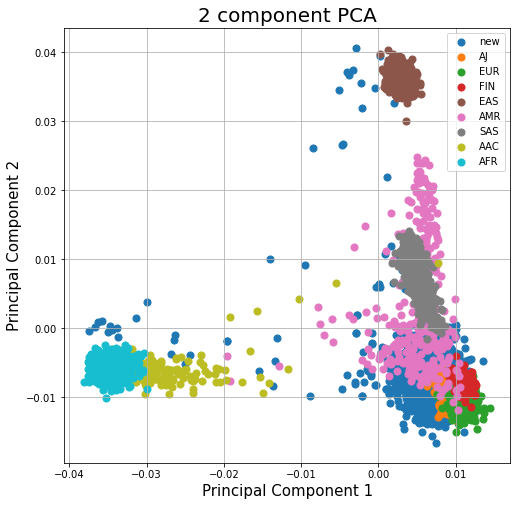

In [102]:
# now plot PCs
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
cmap = cm.get_cmap('tab10')
targets = list(labeled_pca.label.unique())

colors = cmap(np.linspace(0, 1, len(targets)))
for target, color in zip(targets,colors):
    indicesToKeep = labeled_pca['label'] == target
    ax.scatter(labeled_pca.loc[indicesToKeep, 'pc1']
               , labeled_pca.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [93]:
structure = f'/data/vitaled2/ref_panel/fastStructure/structure.py'
fam = pd.read_csv(f'{geno_het_ref_panel}.fam', sep=' ', header=None)
ancestry_labels = f'{ref_dir_path}/ref_panel_ancestry.txt'
faststructure_cmd = f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {geno_het_ref_panel_rand_samp} -o {geno_het_ref_panel_rand_samp}_structure -f {structure}'



In [94]:
fs_complete_swarm = f'{out_path}_fs_complete.swarm'
with open(fs_complete_swarm, 'w') as f:
    f.write(faststructure_cmd)
f.close()

shell_do(f'swarm -f {fs_complete_swarm} -g 16 --time=10:00:00 -t 20 --logdir {out_path}swarm --partition=norm')

Executing: swarm -f /data/vitaled2/test_data/mcgill/_fs_complete.swarm -g 16 --time=10:00:00 -t 20 --logdir /data/vitaled2/test_data/mcgill/swarm --partition=norm


In [95]:
# shell_do(f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {geno_het_ref_panel_rand_samp} -o {geno_het_ref_panel_rand_samp}_structure -f {structure}')
# shell_do(f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {geno_het_ref_panel} -o {geno_het_ref_panel}_structure -f {structure}')
# shell_do(f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {geno_het_ref_panel_final_prune} -o {geno_het_ref_panel_final_prune}_structure -f {structure}')

In [82]:
# after fastStructure finishes running:
# read Q file and create labels
q_df = pd.read_csv(f'{geno_het_ref_panel_rand_samp}_structure.8.meanQ', header=None, sep='\s+')
q_df.columns = [f'pop{i}' for i in range(1,9)]
fam['highest_2_pops'] = q_df.apply(lambda s: s.abs().nlargest(2).index.tolist(), axis=1)
fam['highest_pop'] = q_df.idxmax(axis=1)

q_df['FID'], q_df['IID'], q_df['highest_pop'], q_df['highest_2_pops'] = fam[0], fam[1], fam['highest_pop'], fam['highest_2_pops']


In [83]:
pop = pd.read_csv(ancestry_labels, sep='\t')
q_pop_merged = q_df.merge(pop, left_on=['FID','IID'], right_on=['FID','IID'], how='left')
q_pop_merged.label.fillna('new', inplace=True)
print(q_pop_merged['highest_pop'].value_counts())

pop8    1475
pop2    1124
pop5     315
pop1      51
pop7      27
pop6      18
pop3      18
pop4       9
Name: highest_pop, dtype: int64


In [85]:
q_pop_merged[q_pop_merged['label'] == 'AJ'].describe()
# q_pop_merged[q_pop_merged['label'] == 'EUR'].describe()
# q_pop_merged[q_pop_merged['label'] == 'FIN'].describe()
# q_pop_merged[q_pop_merged['label'] == 'EAS'].describe()
# q_pop_merged[q_pop_merged['label'] == 'AMR'].describe()
# q_pop_merged[q_pop_merged['label'] == 'SAS'].describe()
# q_pop_merged[q_pop_merged['label'] == 'AAC'].describe()
# q_pop_merged[q_pop_merged['label'] == 'AFR'].describe()
# q_pop_merged[q_pop_merged['label'] == 'new'].describe()

,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8
count,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000
mean,0.021251,0.421337,0.007112,0.008123,0.079887,0.004256,0.008692,0.449345
std,0.144296,0.472574,0.081148,0.080899,0.257550,0.065089,0.084556,0.480067
min,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
25%,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
50%,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
75%,0.000010,0.999933,0.000010,0.000010,0.000010,0.000010,0.000010,0.999933
max,0.999933,0.999933,0.999933,0.999933,0.999933,0.999933,0.999933,0.999933


In [75]:
# now bin samples by plate (96 samples per plate) and run individually per plate
ancestry_outpath = f'{out_path}ancestry'
try: 
    os.mkdir(ancestry_outpath) 
except OSError as error: 
    print(error)
    
def chunk_df(df, chunk_size = 96): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1 
    for i in range(num_chunks): 
        chunks.append(df[i*chunk_size:(i+1)*chunk_size]) 
    return chunks

def merge_genos(geno_path1, geno_path2, out_name):
    # attempt 1 at merging genos
    bash1 = f"plink --bfile {geno_path1} --allow-no-sex --bmerge {geno_path2} --out {out_name} --make-bed"
    shell_do(bash1)

    # if {outname}-merge.missnp file created, snps need to be flipped and merge tried again
    if os.path.isfile(f'{out_name}-merge.missnp'):
        bash2 = f"plink --bfile {geno_path1} --allow-no-sex --flip {out_name}-merge.missnp --make-bed --out {geno_path1}_flip"
        bash3 = f"plink --bfile {geno_path1}_flip --allow-no-sex --bmerge {geno_path2} --out {out_name}_flip --make-bed"

        cmds1 = [bash2, bash3]

        for cmd in cmds1:
            shell_do(cmd)

        #if another -merge.missnp file is created, these are likely triallelic positions and must be excluded and then try merge again
        if os.path.isfile(f'{geno_path1}_flip-merge.missnp'):
            bash4 = f"plink --bfile {geno_path1}_flip --allow-no-sex --exclude {out_name}_flip-merge.missnp --out {geno_path1}_flip_pruned --make-bed"
            bash5 = f"plink --bfile {geno_path1}_flip_pruned --allow-no-sex --bmerge {geno_path2} --out  {out_name} --make-bed"

            cmds2 = [bash4, bash5]

            for cmd in cmds2:
                shell_do(cmd)

        # if second attempt at merge is successful, there are no triallelic snps and we can go ahead and move the _flip files to our _merged_ref_panel filenames 
        # for further processing
        else:
            suffix_list = ['bed','bim','fam']
            for suffix in suffix_list:
                shutil.copy(f'{out_name}_flip.{suffix}',f'{out_name}.{suffix}')

    # if first merge works, there are no alleles in need of flipping and no triallelic positions and we can proceed!
    else:
        pass





# def merge_genos(geno_path1, geno_path2, out_name):
#     bash1 = f"plink --bfile {geno_path1} --allow-no-sex --bmerge {geno_path2} --out {out_name}_bin_snplis --make-bed"
#     bash2 = f"plink --bfile {geno_path1} --allow-no-sex --flip {out_name}_bin_snplis-merge.missnp --make-bed --out {out_name}_flip"
#     bash3 = f"plink --bfile {geno_path1}_flip --allow-no-sex --bmerge {geno_path2} --out {out_name}_bin_snplis --make-bed"
#     bash4 = f"plink --bfile {out_name}_flip --allow-no-sex --exclude {out_name}_bin_snplis-merge.missnp --out {out_name}_flip_pruned --make-bed"
#     bash5 = f"plink --bfile {out_name}_flip_pruned --allow-no-sex --bmerge {geno_path2} --out  {out_name} --make-bed"


#     cmds = [bash1, bash2, bash3, bash4, bash5]
    
#     for cmd in cmds:
#         shell_do(cmd)
        
def ld_prune(geno_path, out_name, window_size=50, step_size=10, rsq_thresh=0.1):
    # now prune for LD
    ld_prune1 = f'plink --bfile {geno_path} --allow-no-sex --indep-pairwise {window_size} {step_size} {rsq_thresh} --autosome --out {geno_path}_pruned_data'
    ld_prune2 = f'plink --bfile {geno_path} --allow-no-sex --extract {geno_path}_pruned_data.prune.in --make-bed --out {out_name}'

    ld_prune_cmds = [ld_prune1, ld_prune2]

    for cmd in ld_prune_cmds:
        shell_do(cmd)
        
def random_sample_snps(geno_path, out_name, n=10000):
    rand_samp_snplist = f'{geno_path}_rand_samp.snplist'
    bim = pd.read_csv(f'{geno_path}.bim', sep='\t', header=None)
    ref_panel_random_sample = bim.sample(n, random_state=123)
    ref_panel_random_sample.to_csv(rand_samp_snplist, header=False, index=False, sep='\t')

    rand_sample_cmd = f'plink --bfile {geno_path} --allow-no-sex --extract {rand_samp_snplist} --autosome --make-bed --out {out_name}'
    
    shell_do(rand_sample_cmd)
    
    
    
# pca_cmd = f"plink --bfile {geno_het_ref_panel_rand_samp} --out {geno_het_ref_panel_rand_samp}_pca --make-bed --pca 8"
    
# cmds2 = [rand_sample_cmd, pca_cmd]

# for cmd in cmds2:
#     shell_do(cmd)

[Errno 17] File exists: '/data/vitaled2/test_data/mcgill/ancestry'


In [76]:
# chunk new data into 96 sample plates
chunked = chunk_df(new_samples_fam, chunk_size=96)
faststructure_swarmfile = f'{ancestry_outpath}/_faststructure.swarm'

#point to faststructure script
structure = f'/data/vitaled2/ref_panel/fastStructure/structure.py'

with open(faststructure_swarmfile, 'w') as f:
    for i, df in enumerate(chunked):
        df.columns = ['FID','IID','PAT','MAT','SEX','PHENO']
        plate = f'{ancestry_outpath}/plate{i+1}'
        samples = f'{plate}_samples.txt'
        plate_ref = f'{plate}_ref'
        ld_pruned = f'{plate_ref}_ldprune'
        rand_10k = f'{ld_pruned}_10krandsamp'
        structure_out = f'{rand_10k}_structure'
        # save sample ids for plate
        df[['FID','IID']].to_csv(samples, sep='\t', header=None, index=False)

        # extract samples for plate
        plink_extract = f'plink --bfile {geno_ancestry_prune} --allow-no-sex --keep {samples} --make-bed --out {plate}'
        shell_do(plink_extract)

        #merge geno with ref panel for each plate
        merge_genos(geno_path1=plate, geno_path2=ref_panel, out_name=plate_ref)

        #prune merged ref panel and geno for LD
        ld_prune(geno_path=plate_ref, out_name=rand_10k)
        
#         random_sample_snps(geno_path=ld_pruned, out_name=rand_10k)
        
        #create pca output dir for each plate
#         flashpca_cmd = f'\
# flashpca --bfile {ld_pruned}\
#  -d 8\
#  --outpc {ld_pruned}.pcs\
#  --outvec {ld_pruned}.vec\
#  --outval {ld_pruned}.val\
#  --outpve {ld_pruned}.pve'
        
#         shell_do(flashpca_cmd)
        
#         faststructure_cmd = f'\
# bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh\
#  -i {ld_pruned}\
#  -o {structure_out}\
#  -f {structure}'
        
        
        flashpca_cmd = f'\
flashpca --bfile {rand_10k}\
 -d 8\
 --outpc {rand_10k}.pcs\
 --outvec {rand_10k}.vec\
 --outval {rand_10k}.val\
 --outpve {rand_10k}.pve'
        
        shell_do(flashpca_cmd)
        
#         faststructure_cmd = f'\
# bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh\
#  -i {rand_10k}\
#  -o {structure_out}\
#  -f {structure}'
        
#         f.write(f'{faststructure_cmd}\n')
        
# shell_do(f'swarm -f {faststructure_swarmfile} -g 16 --time=10:00:00 -t 20 --logdir {ancestry_outpath}/swarm --partition=norm')



Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune --allow-no-sex --keep /data/vitaled2/test_data/mcgill/ancestry/plate1_samples.txt --make-bed --out /data/vitaled2/test_data/mcgill/ancestry/plate1
Executing: plink --bfile /data/vitaled2/test_data/mcgill/ancestry/plate1 --allow-no-sex --bmerge /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --out /data/vitaled2/test_data/mcgill/ancestry/plate1_ref --make-bed
Executing: plink --bfile /data/vitaled2/test_data/mcgill/ancestry/plate1 --allow-no-sex --flip /data/vitaled2/test_data/mcgill/ancestry/plate1_ref-merge.missnp --make-bed --out /data/vitaled2/test_data/mcgill/ancestry/plate1_flip
Executing: plink --bfile /data/vitaled2/test_data/mcgill/ancestry/plate1_flip --allow-no-sex --bmerge /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --out /data/vitaled2/test_data/mcgill/ancestry/plate1_ref_flip --make-bed
Executing: plink --bfile /data/vitaled2/test_data/mcgill/anc

KeyboardInterrupt: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

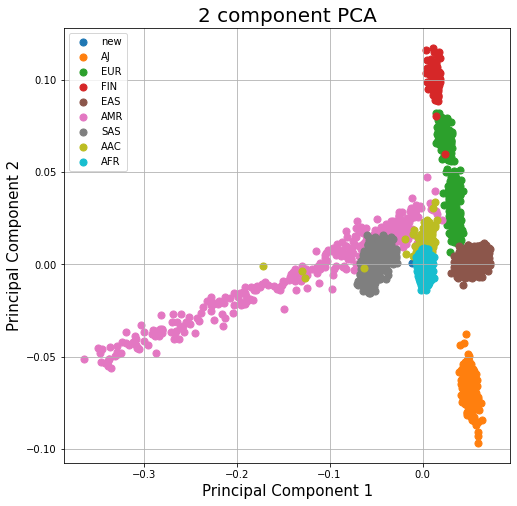

In [81]:
# test plot pca by plate
plate = pd.read_csv(f'{ancestry_outpath}/plate2_ref_ldprune_10krandsamp.pcs', sep='\t')

plate['FID'], plate['IID'] = plate['FID'].astype('str').str.lower(), plate['IID'].astype('str').str.lower()
plate_labeled = plate.merge(combined_labels, how='left', on=['FID','IID'])


def plot_pcs(labeled_pcs_df):
    # now plot PCs
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    cmap = cm.get_cmap('tab10')
    targets = list(labeled_pcs_df.label.unique())
    # targets = ['new', 'EUR']
    colors = cmap(np.linspace(0, 1, len(targets)))
    for target, color in zip(targets,colors):
        indicesToKeep = labeled_pcs_df['label'] == target
        ax.scatter(labeled_pcs_df.loc[indicesToKeep, 'PC4']
                   , labeled_pcs_df.loc[indicesToKeep, 'PC5']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
plot_pcs(plate_labeled)

In [ ]:
f'{ancestry_outpath}/plate1_ref_ldprune_10krandsamp.pcs'

In [56]:
fam = pd.read_csv(f'{rand_10k}.fam', sep=' ', header=None)
q_df = pd.read_csv(f'{rand_10k}_structure.8.meanQ', header=None, sep='\s+')
q_df.columns = [f'pop{i}' for i in range(1,9)]
fam['highest_2_pops'] = q_df.apply(lambda s: s.abs().nlargest(2).index.tolist(), axis=1)
fam['highest_pop'] = q_df.idxmax(axis=1)

q_df['FID'], q_df['IID'], q_df['highest_pop'], q_df['highest_2_pops'] = fam[0], fam[1], fam['highest_pop'], fam['highest_2_pops']

In [57]:
pop = pd.read_csv(ancestry_labels, sep='\t')
q_pop_merged = q_df.merge(pop, left_on=['FID','IID'], right_on=['FID','IID'], how='left')
q_pop_merged.label.fillna('new', inplace=True)
print(q_pop_merged['highest_pop'].value_counts())

pop2    717
pop1    671
pop5    506
pop8    506
pop7    494
pop4    131
pop6      8
pop3      4
Name: highest_pop, dtype: int64


In [74]:
q_pop_merged[q_pop_merged['label'] == 'AJ'].describe()
q_pop_merged[q_pop_merged['label'] == 'EUR'].describe()
q_pop_merged[q_pop_merged['label'] == 'FIN'].describe()
q_pop_merged[q_pop_merged['label'] == 'EAS'].describe()
q_pop_merged[q_pop_merged['label'] == 'AMR'].describe()
# q_pop_merged[q_pop_merged['label'] == 'SAS'].describe()
# q_pop_merged[q_pop_merged['label'] == 'AAC'].describe()
# q_pop_merged[q_pop_merged['label'] == 'AFR'].describe()
# q_pop_merged[q_pop_merged['label'] == 'new'].describe()

,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8
count,347.000000,347.000000,3.470000e+02,347.000000,347.000000,347.000000,347.000000,347.000000
mean,0.035146,0.423575,8.000000e-06,0.415153,0.015749,0.000075,0.092466,0.017831
std,0.094999,0.361544,1.696512e-21,0.333107,0.042213,0.000897,0.209418,0.067742
min,0.000008,0.000008,8.000000e-06,0.000008,0.000008,0.000008,0.000008,0.000008
25%,0.000008,0.000008,8.000000e-06,0.155877,0.000008,0.000008,0.000008,0.000008
50%,0.000008,0.499387,8.000000e-06,0.322670,0.000008,0.000008,0.000008,0.000008
75%,0.000008,0.745167,8.000000e-06,0.703104,0.000008,0.000008,0.013579,0.000008
max,0.831198,0.999947,8.000000e-06,0.999947,0.406275,0.013871,0.999947,0.549135


In [94]:
choosek = 'fastStructure/chooseK.py'
choosek_cmd = f'python {choosek} --input={rand_10k}_structure'
# shell_do(choosek_cmd)
choosek_cmd

'python fastStructure/chooseK.py --input=/data/vitaled2/test_data/FIN/ancestry/plate10_ref_ldprune_10krandsamp_structure'

In [95]:
choosek_cmd = f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh\
 -i {rand_10k}_structure\
 -o {rand_10k}_structure_choosek\
 -f {choosek}'
choosek_cmd        

'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i /data/vitaled2/test_data/FIN/ancestry/plate10_ref_ldprune_10krandsamp_structure -o /data/vitaled2/test_data/FIN/ancestry/plate10_ref_ldprune_10krandsamp_structure_choosek -f fastStructure/chooseK.py'